# Initial Modeling

Using just the hero predictions from 100,000 matches, try and predict which set of 5 heroes will win 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
# importing the cleaned match data
match_df = pd.read_csv("../data/complete_match_df.csv")

### Using count vectorizer to create the feature columns for each match
Each match has 5 heroes for each team (which are denoted with 1, the other 114 options are 0)

This vectorization is done for both radiant and dire teams resulting in a feature matrix of 238 features

In [3]:
rad_cvec = CountVectorizer()
dire_cvec = CountVectorizer()
rad_df = pd.DataFrame(rad_cvec.fit_transform(match_df['radiant']).toarray() , columns = rad_cvec.get_feature_names())
dire_df = pd.DataFrame(dire_cvec.fit_transform(match_df['dire']).toarray() , columns = dire_cvec.get_feature_names())
match_hero_df = pd.concat([rad_df,dire_df], axis=1)

In [4]:
X = match_hero_df
y = match_df['winner'].map({'radiant' : 1 , 'dire' : 0})

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=2020,stratify=y)

#Calculating the baseline accuracy of the data
y_test.value_counts(normalize=True)

1    0.572387
0    0.427613
Name: winner, dtype: float64

The baseline of the model is radiant wins 58% of the time. This is interesting as the developers try and make the game as balanced as possible but there is an 8% increase in winning just by being randomly assigned to the radiant team

### Fitting using Logistic Regressiton in a pipeline

In [17]:
# Used to create dictionary of model params and counter
logreg_model_df = pd.read_csv("../data/logreg_model_params.csv")

#getting the index from the nb_model_params and saving it to a count
logreg_count = logreg_model_df.tail(1).index.values[0]


In [18]:
logreg_pipe = Pipeline([
    ('logreg', LogisticRegression(solver="liblinear"))
])

logreg_pipe_params = {
    "logreg__penalty" : ["l1","l2"],
    "logreg__C" : [0.01,.1,10,100]
}

temp_dict = {}
t0 = time.time()

logreg_gs = GridSearchCV(logreg_pipe,param_grid=logreg_pipe_params,cv=5,verbose=1)

logreg_gs.fit(X_train,y_train)

best_logreg = logreg_gs.best_estimator_

logreg_count += 1

logreg_gs.best_params_["train score"] = best_logreg.score(X_train,y_train)
logreg_gs.best_params_["test score"] = best_logreg.score(X_test,y_test)
temp_dict[f'model_{logreg_count}'] = logreg_gs.best_params_

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
logreg_model_df = pd.concat([logreg_model_df,temp_df])

t1 = time.time()
print(f'This took {t1-t0} seconds!')

logreg_model_df

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   27.0s finished


This took 27.798034191131592 seconds!


,logreg__C,train score,test score,logreg__penalty
0,10.00,0.610657,0.600603,NaN
1,0.10,0.598307,0.589972,NaN
2,0.01,0.598010,0.588907,l2
model_3,0.01,0.599668,0.589750,l2


In [19]:
logreg_model_df.to_csv("../data/logreg_model_params.csv",index=False)

In [20]:
log_preds = best_logreg.predict(X_test)

<Figure size 864x720 with 0 Axes>

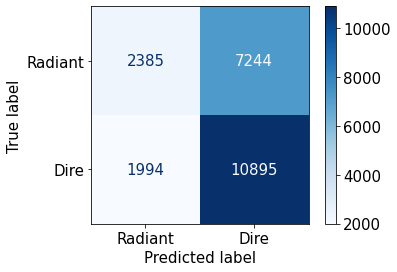

In [21]:
#generate confusion matrix values from logistic regression
tn,fp,fn,tp = confusion_matrix(y_test,log_preds).ravel()
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 15})
plot_confusion_matrix(best_logreg, X_test, y_test, cmap='Blues', values_format='d',display_labels=["Radiant","Dire"]);

# Naive Bayes

In [22]:
# Used to create dictionary of model params and counter
# nb_model_df = pd.read_csv("../data/nb_model_para.csv")
nb_model_df = pd.DataFrame()

In [23]:
#getting the index from the nb_model_params and saving it to a count
# nb_count = nb_model_df.tail(1).index.values[0]
nb_count = 0

In [11]:
temp_dict = {}
t0 = time.time()
nb_pipe = Pipeline([
    ('nb', MultinomialNB())
])

nb_pipe_params = {
}

nb_gs = GridSearchCV(nb_pipe,param_grid=nb_pipe_params,cv=5,verbose=1)
nb_gs.fit(X_train,y_train)

best_nb = nb_gs.best_estimator_

nb_count += 1

nb_gs.best_params_["train score"] = best_nb.score(X_train,y_train)
nb_gs.best_params_["test score"] = best_nb.score(X_test,y_test)
temp_dict[f'model_{nb_count}'] = nb_gs.best_params_

temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
nb_model_df = pd.concat([nb_model_df,temp_df])

t1 = time.time()
print(f'This took {t1-t0} seconds!')

nb_model_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.1s finished


This took 1.621227502822876 seconds!


,train score,test score
model_1,0.597566,0.588685


In [12]:
nb_model_df.to_csv("../data/nb_model_para.csv",index=False)

In [24]:
nb_preds = best_nb.predict(X_test)

<Figure size 864x720 with 0 Axes>

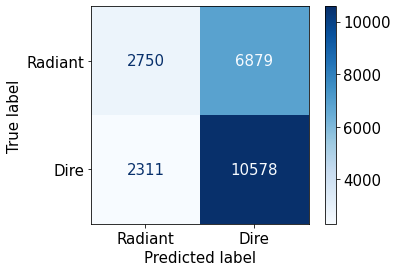

In [25]:
#generate confusion matrix values from Naive Bayes
tn,fp,fn,tp = confusion_matrix(y_test,nb_preds).ravel()
plt.figure(figsize=(12,10))
plt.rcParams.update({'font.size': 15})
plot_confusion_matrix(best_nb, X_test, y_test, cmap='Blues', values_format='d',display_labels=["Radiant","Dire"]);